# Sarcasm Detection using Pre-Trained BERT model from Transformers

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import ast

import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from transformers import TFRobertaModel, RobertaTokenizer
from tensorflow.keras import backend as K
from transformers import TFRobertaForSequenceClassification

from transformers import RobertaTokenizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
features_nltk = pd.read_csv('/content/drive/MyDrive/CS4248/Bert/features_nltk.csv')
features_spacy = pd.read_csv('/content/drive/MyDrive/CS4248/Bert/features_nltk.csv')

data = features_nltk.copy() #features_spacy.copy()
target_col = 'is_sarcastic'
feature_col = 'headline_cleaned' #'lemmatized_text_nltk'

print(data['headline_length'].describe())

X = data[feature_col]  # Assuming 'is_sarcastic' is your target column
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Print distribution of 'is_sarcastic' in each set
print("Training Data is_sarcastic Distribution:")
print(y_train.value_counts(normalize=False))

# print("\nValidation Data is_sarcastic Distribution:")
# print(y_val.value_counts(normalize=False))

print("\nTest Data is_sarcastic Distribution:")
print(y_test.value_counts(normalize=False))

count    26709.000000
mean        60.910592
std         19.184470
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline_length, dtype: float64
Training Data is_sarcastic Distribution:
is_sarcastic
0    11988
1     9379
Name: count, dtype: int64

Test Data is_sarcastic Distribution:
is_sarcastic
0    2997
1    2345
Name: count, dtype: int64


In [4]:
# Define F1-score as a custom metric
def f1_score(y_true, y_pred):
    y_pred = tf.nn.sigmoid(y_pred)  # Convert logits to probabilities
    y_pred = K.round(y_pred)  # Convert probabilities to binary labels (0 or 1)

    tp = K.sum(y_true * y_pred)  # True Positives
    fp = K.sum((1 - y_true) * y_pred)  # False Positives
    fn = K.sum(y_true * (1 - y_pred))  # False Negatives

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

In [5]:
# Enable GPU strategy for multi-GPU training (if multiple GPUs are available)
strategy = tf.distribute.MirroredStrategy()
strategy

## Combine text and engineered features

In [6]:
data.columns

Index(['headline', 'headline_cleaned', 'tokenized_text_nltk',
       'pos_tagged_text_nltk', 'lemmatized_text_nltk', 'headline_length',
       'num_words', 'num_words_vs_length', 'length_vs_num_words',
       'num_stopwords', 'stopwords_vs_length', 'stopwords_vs_words',
       'num_exclamation_marks', 'exclamation_vs_length',
       'exclamation_vs_words', 'num_question_marks', 'question_vs_length',
       'question_vs_words', 'num_quotation_marks', 'quotation_vs_length',
       'quotation_vs_words', 'num_single_quotation_marks',
       'single_quotation_vs_length', 'single_quotation_vs_words',
       'num_punctuation_marks', 'punctuation_vs_length',
       'punctuation_vs_words', 'num_unique_words', 'num_repeated_words',
       'unique_vs_length', 'unique_vs_words', 'repeated_vs_length',
       'repeated_vs_words', 'num_nouns', 'num_adjectives', 'num_verbs',
       'nouns_vs_length', 'nouns_vs_words', 'adjectives_vs_length',
       'adjectives_vs_words', 'verbs_vs_length', 'verbs_vs_w

In [7]:
features_nltk = pd.read_csv('/content/drive/MyDrive/CS4248/Bert/features_nltk.csv')
features_spacy = pd.read_csv('/content/drive/MyDrive/CS4248/Bert/features_spacy.csv')

data = features_nltk.copy() #features_spacy.copy()
target_col = 'is_sarcastic'
numerical_col = ['headline_length',
       'num_words', 'num_words_vs_length', 'length_vs_num_words',
       'num_stopwords', 'stopwords_vs_length', 'stopwords_vs_words',
       'num_exclamation_marks', 'exclamation_vs_length',
       'exclamation_vs_words', 'num_question_marks', 'question_vs_length',
       'question_vs_words', 'num_quotation_marks', 'quotation_vs_length',
       'quotation_vs_words', 'num_single_quotation_marks',
       'single_quotation_vs_length', 'single_quotation_vs_words',
       'num_punctuation_marks', 'punctuation_vs_length',
       'punctuation_vs_words', 'num_unique_words', 'num_repeated_words',
       'unique_vs_length', 'unique_vs_words', 'repeated_vs_length',
       'repeated_vs_words', 'num_nouns', 'num_adjectives', 'num_verbs',
       'nouns_vs_length', 'nouns_vs_words', 'adjectives_vs_length',
       'adjectives_vs_words', 'verbs_vs_length', 'verbs_vs_words',
       'readability', 'sentiment']
feature_col = 'headline_cleaned' #'lemmatized_text_nltk'

print(data['headline_length'].describe())

X = data[[feature_col] + numerical_col]  # Assuming 'is_sarcastic' is your target column
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(y_train.value_counts(normalize=False))

print("\nTest Data is_sarcastic Distribution:")
print(y_test.value_counts(normalize=False))

count    26709.000000
mean        60.910592
std         19.184470
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline_length, dtype: float64
is_sarcastic
0    11988
1     9379
Name: count, dtype: int64

Test Data is_sarcastic Distribution:
is_sarcastic
0    2997
1    2345
Name: count, dtype: int64


# BERT Tokenizer


In [8]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
print(model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [9]:
token_lens = []

for txt in X_train[feature_col]:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

np.int64(47)

In [10]:
MAX_LEN=64

def tokenize_bert(data, max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_bert(X_train[feature_col], MAX_LEN)
test_input_ids, test_attention_masks = tokenize_bert(X_test[feature_col], MAX_LEN)

In [ ]:
import tensorflow as tf
from transformers import TFBertModel

import tensorflow as tf
from transformers import TFBertModel, TFAutoModel

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        output = self.bert_model(input_ids=inputs[0], attention_mask=inputs[1])
        return output[0]  # Return the last hidden state

def create_model(bert_model, feature_size=39,  # Example feature size
                 max_len=MAX_LEN, dense_units=64, dropout_rate=0.2):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")
    extra_input = tf.keras.Input(shape=(feature_size,), dtype=tf.float32, name="extra_features")

    bert_layer = BertLayer(bert_model)
    bert_output = bert_layer([input_ids, attention_masks])

    bert_output = tf.keras.layers.GlobalAveragePooling1D()(bert_output)
    combined = tf.keras.layers.Concatenate()([bert_output, extra_input])
    dense = tf.keras.layers.Dense(dense_units, activation='relu')(combined)
    dense = tf.keras.layers.Dropout(dropout_rate)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, extra_input], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the Bert model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Create the model
model = create_model(bert_model)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ bert_layer[0][0]       │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 807)            │              0 │ global_average_poolin… │
│                           │                        │                │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         51,712 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,777 (202.25 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit([train_input_ids,train_attention_masks, X_train.drop(feature_col, axis=1)], y_train,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 111s 153ms/step - binary_accuracy: 0.7227 - f1_score: 0.6081 - loss: 0.6342 - val_binary_accuracy: 0.8248 - val_f1_score: 0.6162 - val_loss: 0.3882
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 128s 141ms/step - binary_accuracy: 0.8416 - f1_score: 0.6068 - loss: 0.3632 - val_binary_accuracy: 0.8622 - val_f1_score: 0.6162 - val_loss: 0.3284
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 143ms/step - binary_accuracy: 0.8575 - f1_score: 0.6059 - loss: 0.3263 - val_binary_accuracy: 0.8685 - val_f1_score: 0.6162 - val_loss: 0.3101
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 135ms/step - binary_accuracy: 0.8701 - f1_score: 0.6088 - loss: 0.3025 - val_binary_accuracy: 0.8734 - val_f1_score: 0.6162 - val_loss: 0.2950
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 88s 147ms/step - binary_accuracy: 0.8745 - f1_score: 0.6135 - loss: 0.2944 - val_binary_accuracy: 0.8755 - val_f1_score: 0.6162 - val_loss: 0.2915
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 138ms/step - binary

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks, X_test.drop(feature_col, axis=1)])
y_pred_bert = (result_bert > 0.5).astype(int)

167/167 ━━━━━━━━━━━━━━━━━━━━ 34s 172ms/step


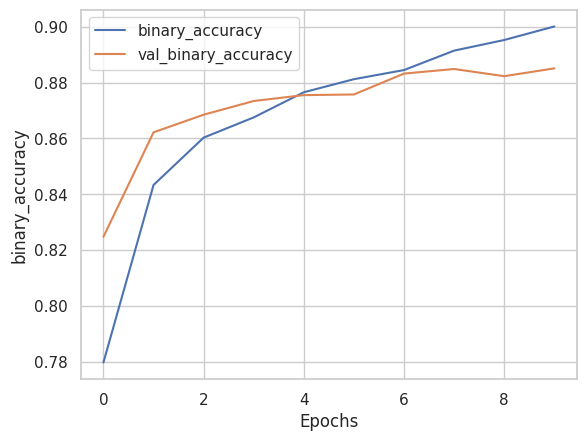

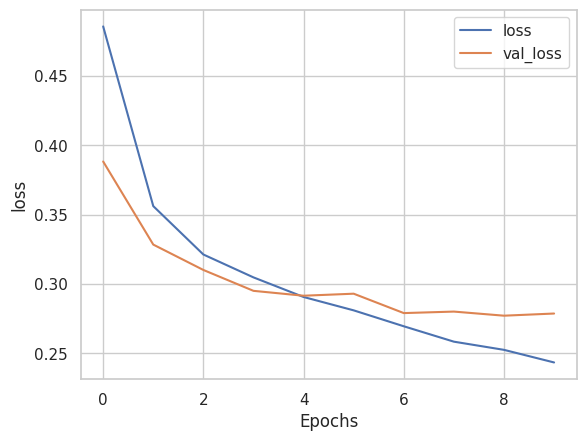

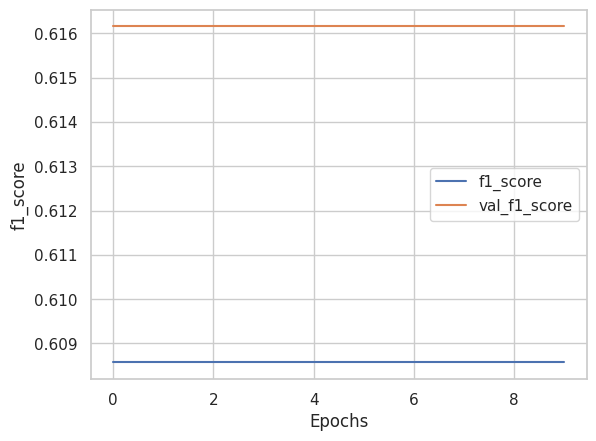

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'binary_accuracy')
plot_graphs(history, 'loss')
plot_graphs(history, 'f1_score')

## Hyperparameter tuning

In [ ]:
features_nltk = pd.read_csv('/content/drive/MyDrive/CS4248/Bert/features_nltk.csv')

data = features_nltk.copy()
target_col = 'is_sarcastic'
numerical_col = ['headline_length',
       'num_words', 'num_words_vs_length', 'length_vs_num_words',
       'num_stopwords', 'stopwords_vs_length', 'stopwords_vs_words',
       'num_exclamation_marks', 'exclamation_vs_length',
       'exclamation_vs_words', 'num_question_marks', 'question_vs_length',
       'question_vs_words', 'num_quotation_marks', 'quotation_vs_length',
       'quotation_vs_words', 'num_single_quotation_marks',
       'single_quotation_vs_length', 'single_quotation_vs_words',
       'num_punctuation_marks', 'punctuation_vs_length',
       'punctuation_vs_words', 'num_unique_words', 'num_repeated_words',
       'unique_vs_length', 'unique_vs_words', 'repeated_vs_length',
       'repeated_vs_words', 'num_nouns', 'num_adjectives', 'num_verbs',
       'nouns_vs_length', 'nouns_vs_words', 'adjectives_vs_length',
       'adjectives_vs_words', 'verbs_vs_length', 'verbs_vs_words',
       'readability', 'sentiment']
feature_col = 'headline_cleaned' #'lemmatized_text_nltk'

print(data['headline_length'].describe())

X = data[[feature_col] + numerical_col]  # Assuming 'is_sarcastic' is your target column
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Print distribution of 'is_sarcastic' in each set
print("Training Data is_sarcastic Distribution:")
print(y_train.value_counts(normalize=False))

# print("\nValidation Data is_sarcastic Distribution:")
# print(y_val.value_counts(normalize=False))

print("\nTest Data is_sarcastic Distribution:")
print(y_test.value_counts(normalize=False))

count    26709.000000
mean        60.910592
std         19.184470
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: headline_length, dtype: float64
Training Data is_sarcastic Distribution:
is_sarcastic
0    11988
1     9379
Name: count, dtype: int64

Test Data is_sarcastic Distribution:
is_sarcastic
0    2997
1    2345
Name: count, dtype: int64


In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from transformers import TFBertModel

import tensorflow as tf
from transformers import TFBertModel, TFAutoModel

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        output = self.bert_model(input_ids=inputs[0], attention_mask=inputs[1])
        return output[0]  # Return the last hidden state

def create_model(bert_model, feature_size=39,  # Example feature size
                 max_len=MAX_LEN, dense_units=64, dropout_rate=0.2,
                 opt=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5),
                 activation_func='relu'):

    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")
    extra_input = tf.keras.Input(shape=(feature_size,), dtype=tf.float32, name="extra_features")

    bert_layer = BertLayer(bert_model)
    bert_output = bert_layer([input_ids, attention_masks])

    bert_output = tf.keras.layers.GlobalAveragePooling1D()(bert_output)
    combined = tf.keras.layers.Concatenate()([bert_output, extra_input])
    dense = tf.keras.layers.Dense(dense_units, activation='relu')(combined)
    dense = tf.keras.layers.Dropout(dropout_rate)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, extra_input], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the Bert model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Create the model
model = create_model(bert_model)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ bert_layer[0][0]       │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 807)            │              0 │ global_average_poolin… │
│                           │                        │                │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         51,712 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,777 (202.25 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import keras_tuner as kt

def model_builder(hp):
    # Define hyperparameter search space
    hp_dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid', 'elu', 'selu', 'swish'])

    # Load the Bert model inside model_builder
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')

    # Build the model with hyperparameters
    model = create_model(
        bert_model,
        dense_units=hp_dense_units,
        dropout_rate=hp_dropout_rate,
        opt=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), # Pass optimizer instance
        activation_func=hp_activation
    )

    print(model.summary())

    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_binary_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='/content/drive/MyDrive/CS4248/Bert',
                     project_name='bert_tuned')

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Perform hyperparameter search
tuner.search([train_input_ids, train_attention_masks, X_train.drop(feature_col, axis=1)],
             y_train,
             epochs=20,
             validation_split=0.2,
             callbacks=[stop_early])


Trial 26 Complete [00h 12m 59s]
val_binary_accuracy: 0.8876930475234985

Best val_binary_accuracy So Far: 0.8876930475234985
Total elapsed time: 05h 00m 38s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
64                |192               |dense_units
0.4               |0.2               |dropout_rate
0.0001            |0.001             |learning_rate
swish             |selu              |activation
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ bert_layer[0][0]       │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 807)            │              0 │ global_average_poolin… │
│                           │                        │                │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         51,712 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,777 (202.25 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 109s 170ms/step - binary_accuracy: 0.5170 - f1_score: 0.6035 - loss: 1.6094 - val_binary_accuracy: 0.7824 - val_f1_score: 0.6162 - val_loss: 0.5021
Epoch 2/20
534/535 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - binary_accuracy: 0.6745 - f1_score: 0.6100 - loss: 0.6508

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dense_units')}, the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit([train_input_ids, train_attention_masks, X_train.drop(feature_col, axis=1)],
                    y_train,
                    epochs=6,
                    validation_split=0.2)
# Evaluate the model on the test set
loss, accuracy, f1_score = model.evaluate([test_input_ids, test_attention_masks, X_test.drop(feature_col, axis=1)], y_test, verbose=2)
print('Test accuracy:', accuracy)
print('Test f1_score:', f1_score)

In [11]:
# Just hardcode the best params from finetuning

import tensorflow as tf
from transformers import TFBertModel, TFAutoModel

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        output = self.bert_model(input_ids=inputs[0], attention_mask=inputs[1])
        return output[0]  # Last hidden state

def create_model(
    bert_model,
    feature_size=39,  # Example feature size
    max_len=64,       # Assuming MAX_LEN is 64 from your previous logs
    dense_units=192,
    dropout_rate=0.2,
    opt=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5),
    activation_func='selu'
):
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    f1_score = tf.keras.metrics.F1Score()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32', name="input_ids")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32', name="attention_mask")
    extra_input = tf.keras.Input(shape=(feature_size,), dtype=tf.float32, name="extra_features")

    bert_layer = BertLayer(bert_model)
    bert_output = bert_layer([input_ids, attention_masks])
    bert_output = tf.keras.layers.GlobalAveragePooling1D()(bert_output)

    combined = tf.keras.layers.Concatenate()([bert_output, extra_input])
    dense = tf.keras.layers.Dense(dense_units, activation=activation_func)(combined)
    dense = tf.keras.layers.Dropout(dropout_rate)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, extra_input], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy, f1_score])
    return model

# Load the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Create model with hardcoded best hyperparams
model = create_model(bert_model)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 64)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 64, 768)        │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ bert_layer[0][0]       │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 807)            │              0 │ global_average_poolin… │
│                           │                        │                │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 192)            │        155,136 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 192)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            193 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 155,329 (606.75 KB)

 Trainable params: 155,329 (606.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit([train_input_ids, train_attention_masks, X_train.drop(feature_col, axis=1)],
                    y_train,
                    epochs=6,
                    validation_split=0.2)

Epoch 1/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 100s 152ms/step - binary_accuracy: 0.7205 - f1_score: 0.6085 - loss: 0.7951 - val_binary_accuracy: 0.8540 - val_f1_score: 0.6162 - val_loss: 0.3396
Epoch 2/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 132s 144ms/step - binary_accuracy: 0.8398 - f1_score: 0.6012 - loss: 0.3603 - val_binary_accuracy: 0.8510 - val_f1_score: 0.6162 - val_loss: 0.3494
Epoch 3/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 144ms/step - binary_accuracy: 0.8485 - f1_score: 0.6107 - loss: 0.3396 - val_binary_accuracy: 0.8610 - val_f1_score: 0.6162 - val_loss: 0.3179
Epoch 4/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 145ms/step - binary_accuracy: 0.8697 - f1_score: 0.6080 - loss: 0.3112 - val_binary_accuracy: 0.8772 - val_f1_score: 0.6162 - val_loss: 0.2972
Epoch 5/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 144ms/step - binary_accuracy: 0.8705 - f1_score: 0.6067 - loss: 0.2933 - val_binary_accuracy: 0.8613 - val_f1_score: 0.6162 - val_loss: 0.3200
Epoch 6/6
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 145ms/step - binary_accur

In [13]:
# Evaluate the model on the test set
loss, accuracy, f1_score = model.evaluate([test_input_ids, test_attention_masks, X_test.drop(feature_col, axis=1)], y_test, verbose=2)
print('Test accuracy:', accuracy)
print('Test f1_score:', f1_score)

167/167 - 19s - 116ms/step - binary_accuracy: 0.8692 - f1_score: 0.6101 - loss: 0.3156
Test accuracy: 0.8691501021385193
Test f1_score: 0.610120952129364


In [14]:
result = model.predict([test_input_ids,test_attention_masks, X_test.drop(feature_col, axis=1)])
y_pred = (result > 0.5).astype(int)

167/167 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step


In [15]:
print('\tClassification Report for Bert (hyperparameter finetuning):\n\n',classification_report(y_test,y_pred))

	Classification Report for Bert (hyperparameter finetuning):

               precision    recall  f1-score   support

           0       0.84      0.94      0.89      2997
           1       0.91      0.78      0.84      2345

    accuracy                           0.87      5342
   macro avg       0.88      0.86      0.86      5342
weighted avg       0.87      0.87      0.87      5342



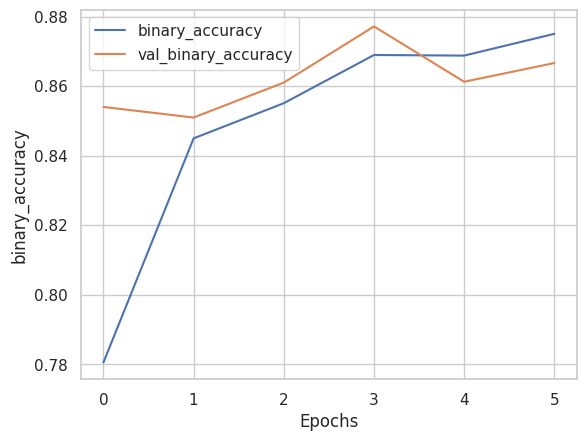

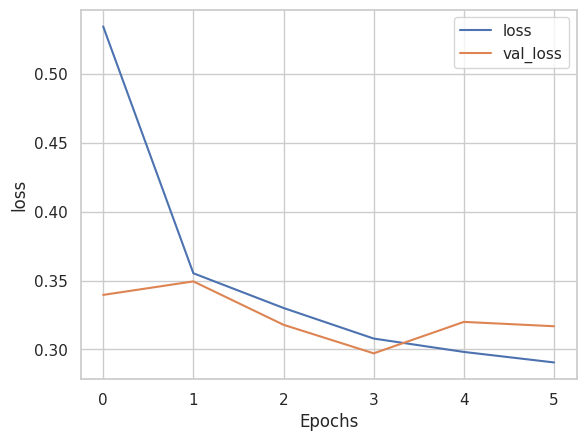

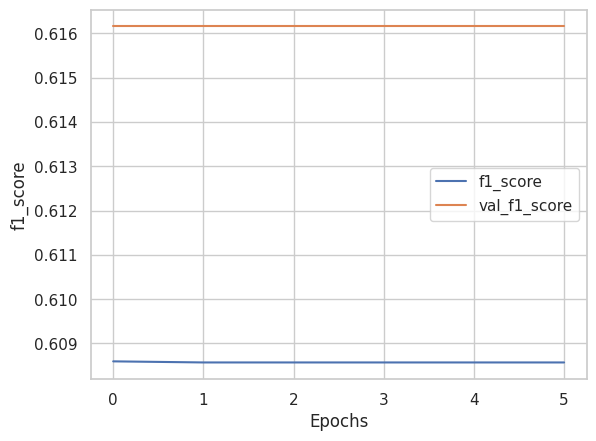

In [16]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'binary_accuracy')
plot_graphs(history, 'loss')
plot_graphs(history, 'f1_score')